#DATA PREPROCESSING
###USD/TRY (Sell) data from CBRT
###Jan 2006 to Dec 2024
#### We wanted to minimize the effects of 2001 February crisis and free exchange rate decision.

In [ ]:
!pip install scipy
!pip install numpy 
!pip install seaborn
!pip install imbalanced-learn
!pip install xgboost

In [231]:
!pip install scikit-learn

In [279]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.2 MB/s eta 0:00:00


In [184]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

In [185]:
path_to_USD_TRY = "data/USD_TRY.xlsx"


df = (pd.read_excel(path_to_USD_TRY)
        .rename(columns={"Tarih": "date", "TP DK USD S YTL": "price"}))

#change it to date format
df["date"] = pd.to_datetime(df["date"], format='%d-%m-%Y', errors='coerce')

#price column contains commas, replace them with dots for conversion
df["price"] = pd.to_numeric(
    df["price"].astype(str).str.replace(',', '.', regex=False),
    errors='coerce'
)

# Create 'is_holiday' feature for missing values
df["is_holiday"] = df["price"].isna().astype(int)

#back fill for first day
df.loc[df.index[0], 'price'] = df.loc[df.index[1], 'price']

#forward fill for missing values.
df["price"] = df["price"].ffill()

print(df.columns)

# 6. Set 'date' as index and sort
if not df.empty:
    df = df.set_index("date").sort_index()
else:
    print("Warning: DataFrame is empty after processing (date/price conversion or NaN handling).")


print(df.head())
print("\nDataframe Info:")
df.info()

df.to_csv("data/USD_TRY_filled.csv", index=True)

Index(['date', 'price', 'is_holiday'], dtype='object')
             price  is_holiday
date                          
2006-01-01  1.3483           1
2006-01-02  1.3483           0
2006-01-03  1.3506           0
2006-01-04  1.3484           0
2006-01-05  1.3381           0

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6940 entries, 2006-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       6940 non-null   float64
 1   is_holiday  6940 non-null   int32  
dtypes: float64(1), int32(1)
memory usage: 135.5 KB


In [186]:

# --------------------------------------------------------------------
# 0) DATA PREP – Removing non-trading days
# -------------------------------------------------------------------
df = df[df['is_holiday'] == 0].copy()              
# --------------------------------------------------------------------
# 1) Daily Simple Returns 
# --------------------------------------------------------------------
df['daily_ret'] = df['price'].pct_change()

# --------------------------------------------------------------------
# 2) TECHNICAL INDICATORS (from trading days)
# --------------------------------------------------------------------
df['SMA20'] = df['price'].rolling(20).mean()
df['SMA50'] = df['price'].rolling(50).mean()
df['MA_GAP50'] = (df['price'] / df['SMA50'] - 1) * 100

def compute_rsi(s, n=14):
    d = s.diff()
    up = d.clip(lower=0).rolling(n).mean()
    dn = (-d.clip(upper=0)).rolling(n).mean()
    rs = up / dn
    return 100 - 100 / (1 + rs)

df['RSI14'] = compute_rsi(df['price'])

def compute_macd(price, fast=12, slow=26, signal=9):
    ema_fast  = price.ewm(span=fast,  adjust=False).mean()
    ema_slow  = price.ewm(span=slow,  adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_ln = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_ln
    return macd_line, macd_hist, signal_ln

df['MACD_line'], df['MACD_hist'], df['MACD_signal'] = compute_macd(df['price'])

# --------------------------------------------------------------------
# 3) MONTHLY FEATURES
# --------------------------------------------------------------------
def longest_streak(series, positive=True):
    max_streak = streak = 0
    for v in series.dropna():
        if (v > 0) if positive else (v < 0):
            streak += 1
        else:
            max_streak, streak = max(max_streak, streak), 0
    return max(max_streak, streak)

grp = pd.Grouper(freq='M')          # group by month
# Create a new DataFrame for monthly features
monthly = pd.DataFrame(index=df.resample('M').last().index)

#   — volatility, skew, kurtosis, max/min returns —
monthly['vol_1m']       = df['daily_ret'].groupby(grp).std()
monthly['ann_vol_1m_%'] = monthly['vol_1m'] * np.sqrt(252) * 100
monthly['skew_1m']      = df['daily_ret'].groupby(grp).apply(skew)
monthly['kurt_1m']      = df['daily_ret'].groupby(grp).apply(kurtosis)
monthly['max_ret_1m']   = df['daily_ret'].groupby(grp).max()
monthly['min_ret_1m']   = df['daily_ret'].groupby(grp).min()

#   — streak-
monthly['streak_up_1m']   = df['daily_ret'].groupby(grp).apply(lambda x: longest_streak(x, True))
monthly['streak_down_1m'] = df['daily_ret'].groupby(grp).apply(lambda x: longest_streak(x, False))

#   —end of the month features—
for col in ['RSI14', 'MA_GAP50', 'MACD_hist']:
    monthly[col + '_last'] = df[col].resample('M').last()

# --------------------------------------------------------------------
# 4) HIGH-VOL label (>=%10 is high volatility month)
# --------------------------------------------------------------------
monthly['high_vol'] = (monthly['ann_vol_1m_%'] >= 10).astype(int)

# --------------------------------------------------------------------
# 5) cleaning
# --------------------------------------------------------------------
print(f"Number of rows in monthly: {len(monthly)}")
print("Monthly DataFrame before cleaning:")
print(monthly.head())
# Drop rows with NaN values

monthly.dropna(inplace=True)
print(f"Number of rows after dropping: {len(monthly)}")
print("Monthly DataFrame after cleaning:")
print(monthly.head())




C:\Users\acer\AppData\Local\Temp\ipykernel_18280\3773819621.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grp = pd.Grouper(freq='M')          # takvim ayı gruplaması
C:\Users\acer\AppData\Local\Temp\ipykernel_18280\3773819621.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = pd.DataFrame(index=df.resample('M').last().index)


Number of rows in monthly: 228
Monthly DataFrame before cleaning:
              vol_1m  ann_vol_1m_%   skew_1m   kurt_1m  max_ret_1m  \
date                                                                 
2006-01-31  0.002862      4.543731       NaN       NaN    0.002718   
2006-02-28  0.004786      7.597604  0.319344  0.006352    0.010017   
2006-03-31  0.007127     11.313236  0.082200 -0.645419    0.016834   
2006-04-30  0.003423      5.433343 -0.357228  0.565857    0.005614   
2006-05-31  0.015822     25.116668  1.140709  1.399050    0.048902   

            min_ret_1m  streak_up_1m  streak_down_1m  RSI14_last  \
date                                                               
2006-01-31   -0.007639             3               4   34.493671   
2006-02-28   -0.008941             2               3   43.141852   
2006-03-31   -0.010669             5               3   49.449619   
2006-04-30   -0.009456             3               7   41.166078   
2006-05-31   -0.020682             

C:\Users\acer\AppData\Local\Temp\ipykernel_18280\3773819621.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly[col + '_last'] = df[col].resample('M').last()
C:\Users\acer\AppData\Local\Temp\ipykernel_18280\3773819621.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly[col + '_last'] = df[col].resample('M').last()
C:\Users\acer\AppData\Local\Temp\ipykernel_18280\3773819621.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly[col + '_last'] = df[col].resample('M').last()


We dropped the first two months as MA50 data is not avaliable for them

In [187]:
# Count of high_vol == 1
high_vol_count = monthly['high_vol'].sum()

# Ratio of 1's and 0's in high_vol
high_vol_ratio = monthly['high_vol'].value_counts(normalize=True)

# Column names of the dataframe
column_names = monthly.columns.tolist()

# Drop 'vol_1m' column
monthly = monthly.drop(columns=['vol_1m'])

print(f"Count of high_vol == 1: {high_vol_count}")
print("Ratio of 1's and 0's in high_vol:")
print(high_vol_ratio)
print("Column names after dropping 'vol_1m':")
print(monthly.columns.tolist())

Count of high_vol == 1: 115
Ratio of 1's and 0's in high_vol:
high_vol
1    0.50885
0    0.49115
Name: proportion, dtype: float64
Column names after dropping 'vol_1m':
['ann_vol_1m_%', 'skew_1m', 'kurt_1m', 'max_ret_1m', 'min_ret_1m', 'streak_up_1m', 'streak_down_1m', 'RSI14_last', 'MA_GAP50_last', 'MACD_hist_last', 'high_vol']


Plot the graph of Annualized Volatility (%)

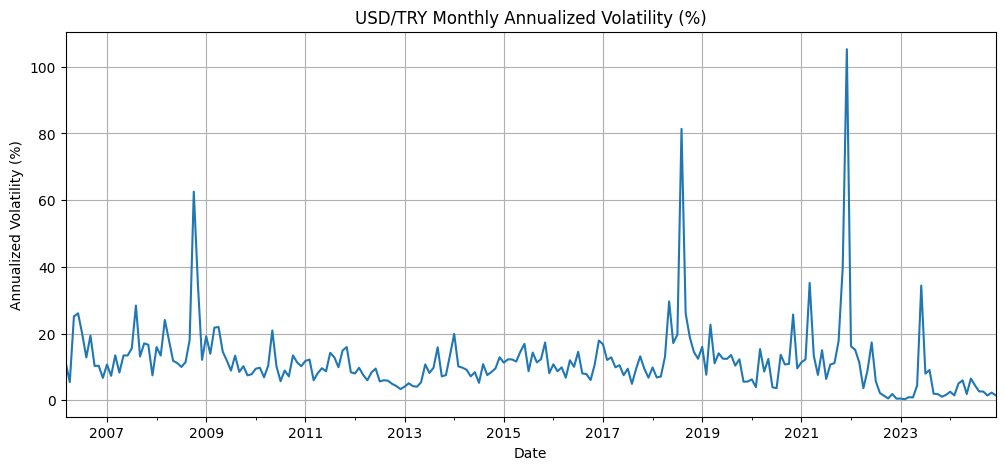

In [189]:

monthly['ann_vol_1m_%'].plot(figsize=(12, 5), title='USD/TRY Monthly Annualized Volatility (%)')
plt.ylabel('Annualized Volatility (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

We will be ignoring first 2 months 2006-01 and 2006-02 as MA_50 is not avaliable.

In [190]:
ecsu_df = pd.read_excel("data\ECSU_Index.xlsx")
ecsu_values = ecsu_df.iloc[3:229, 1]


monthly["ECSU"] = ecsu_values.values

monthly["ECSU"] = monthly["ECSU"].astype(float)

ECSU Citation:
Kilic, I. and Balli, F. (2024). Measuring economic country-specific uncertainty in Türkiye. Empirical Economics, 67, pp.1649–1689. Available at: https://doi.org/10.1007/s00181-024-

Adding the VIX close data

In [309]:
monthly = pd.read_csv("data/monthly2.csv", index_col="date", parse_dates=True)

#get the vix_close from the enriched data
df_extra_features = pd.read_csv("data/USD_TRY_monthly_enriched.csv", index_col="date", parse_dates=True)

#choose the columns to add
cols_to_add = ['vix_close']
features = df_extra_features[cols_to_add].copy()

#join to the monthly dataframe
monthly = monthly.join(features)

print(monthly[['vix_close']].head())
print(monthly['vix_close'].count())

            vix_close
date                 
2006-03-31      11.39
2006-04-30      11.59
2006-05-31      16.44
2006-06-30      13.08
2006-07-31      14.95
226


ADDING THE ANNUAL CPI OF TURKEY
CPI-TÜFE: 2006-03 and 2024-12
from TÜİK

In [310]:
cpi_df = pd.read_csv("cpi_annual_eom_2006-2024.csv", usecols=["Annual_CPI"])

monthly["Annual_CPI"] = cpi_df["Annual_CPI"].values

print(monthly[["Annual_CPI"]].head())

            Annual_CPI
date                  
2006-03-31        8.16
2006-04-30        8.83
2006-05-31        9.86
2006-06-30       10.12
2006-07-31       11.69


More data from CBRT

In [311]:
df1 = pd.read_csv("tcmb_data/avrupa_brent_petrol_clean.csv", usecols=["price"])
df2 = pd.read_csv("tcmb_data/cari_işlemler_hesabı_clean.csv",  usecols=["price"])
df3 = pd.read_csv("tcmb_data/TCMB_altın_rezerv_clean.csv", usecols=["price"])
df4 = pd.read_csv("tcmb_data\TCMB_döviz_rezerv_clean.csv",  usecols=["price"])

monthly["Oil"] = df1["price"].values
monthly["Current_Account"] = df2["price"].values
monthly["Gold_Reserve"] = df3["price"].values
monthly["Forex_Reserve"] = df4["price"].values

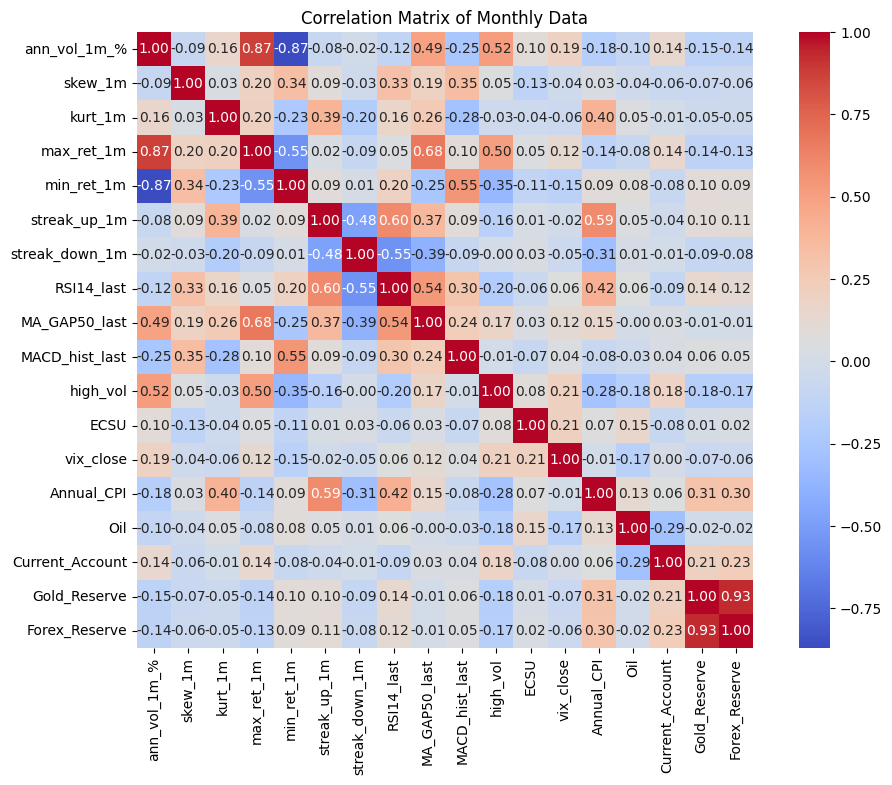

In [313]:
import seaborn as sns

import matplotlib.pyplot as plt

corr = monthly.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Monthly Data")
plt.show()

RANDOM FOREST

Splitter Class

In [314]:
from sklearn.model_selection import BaseCrossValidator
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import TimeSeriesSplit

class TimeSeriesSplitBoth(BaseCrossValidator):
    """
    Time-series CV: each test block must have at least
    `min_pos` positives and `min_neg` negatives.
    """
    def __init__(self, n_splits=5, test_size=12, min_pos=1, min_neg=1):
        self.n_splits  = n_splits
        self.test_size = test_size
        self.min_pos   = min_pos
        self.min_neg   = min_neg

    def split(self, X, y, groups=None):
        n = _num_samples(X)
        first = max(0, n - self.test_size * self.n_splits)

        for start in range(first, n, self.test_size):
            end = start + self.test_size

            # grow the window until both class counts satisfied
            while end < n:
                pos = y.iloc[start:end].sum()
                neg = (end - start) - pos
                if pos >= self.min_pos and neg >= self.min_neg:
                    break
                end += 1

            # yield only if both classes present
            if end <= n:
                pos = y.iloc[start:end].sum()
                neg = (end - start) - pos
                if pos >= self.min_pos and neg >= self.min_neg:
                    yield np.arange(0, start), np.arange(start, end)

    def get_n_splits(self, X=None, y=None, groups=None):
        n = _num_samples(X)
        first = max(0, n - self.test_size * self.n_splits)
        count = 0
        for start in range(first, n, self.test_size):
            end = start + self.test_size
            while end < n:
                pos = y.iloc[start:end].sum()
                neg = (end - start) - pos
                if pos >= self.min_pos and neg >= self.min_neg:
                    break
                end += 1
            if end <= n:
                pos = y.iloc[start:end].sum()
                neg = (end - start) - pos
                if pos >= self.min_pos and neg >= self.min_neg:
                    count += 1
        return count


Setting the X and y

In [328]:
# --- label ---
monthly['high_vol_next'] = monthly['high_vol'].shift(-1)
monthly.dropna(subset=['high_vol_next'], inplace=True)


# --- full X / y ---
y_full = monthly['high_vol_next'].astype(int)
X_full = monthly.drop(columns=['high_vol', 'high_vol_next'])

Holdout choice

In [316]:
HOLDOUT = 48                     
X_hold  = X_full.iloc[-HOLDOUT:]
y_hold  = y_full.iloc[-HOLDOUT:]

X_model = X_full.iloc[:-HOLDOUT]  
y_model = y_full.iloc[:-HOLDOUT]

In [317]:
cv_12 = TimeSeriesSplitBoth(n_splits=5, test_size=12, min_pos=1, min_neg=1)
cv_18 = TimeSeriesSplitBoth(n_splits=4, test_size=18, min_pos=1, min_neg=1)
cv_24 = TimeSeriesSplitBoth(n_splits=4, test_size=24, min_pos=1, min_neg=1)

CV = cv_18        # changeable to cv_12 for 12-month splits
print(f"Number of training samples: {len(X_model)}")

Number of training samples: 177


BalancedRandomForest model

In [330]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

brf = BalancedRandomForestClassifier(random_state=42)

grid = {
    "n_estimators": [100, 200],
    "max_depth"   : [3, 4],
}

gs = GridSearchCV(
        brf, grid,
        scoring=make_scorer(f1_score, pos_label=1),
        cv=CV,
        n_jobs=-1,
        verbose=2,
        refit=True)

gs.fit(X_model, y_model)
print("Best params:", gs.best_params_)
print("Best CV F1:", round(gs.best_score_, 3))


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best params: {'max_depth': 3, 'n_estimators': 200}
Best CV F1: 0.657


Evaluation

In [331]:
from sklearn.metrics import (
    precision_recall_curve, f1_score,
    confusion_matrix, classification_report)

model = gs.best_estimator_.fit(X_model, y_model)
proba = model.predict_proba(X_hold)[:, 1]

pr, re, th = precision_recall_curve(y_hold, proba)
f1_macro = [f1_score(y_hold, proba > t, average='macro') for t in th]
best_t = th[np.argmax(f1_macro)]

y_pred = (proba > best_t).astype(int)

print(f"\nOptimum threshold = {best_t:.2f}")
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred, digits=3, zero_division=0))


Optimum threshold = 0.54
[[25  8]
 [ 3 12]]
              precision    recall  f1-score   support

           0      0.893     0.758     0.820        33
           1      0.600     0.800     0.686        15

    accuracy                          0.771        48
   macro avg      0.746     0.779     0.753        48
weighted avg      0.801     0.771     0.778        48



LightGBM

In [320]:
# ==============================================================
# Hold-out
# ============================================================== 
HOLDOUT = 48                                   
X_hold  = X_full.iloc[-HOLDOUT:]               
y_hold  = y_full.iloc[-HOLDOUT:]

X_model = X_full.iloc[:-HOLDOUT]               
y_model = y_full.iloc[:-HOLDOUT]

In [321]:
cv = TimeSeriesSplitBoth(
        n_splits = 4,          
        test_size = 18,       
        min_pos = 1,
        min_neg = 1
)

In [332]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

ratio = (y_model == 0).sum() / (y_model == 1).sum()    # class imbalance

lgb = LGBMClassifier(
        objective      = "binary",
        max_depth      = 3,
        subsample      = 0.8,
        colsample_bytree = 0.7,
        random_state   = 42,
        n_jobs         = -1,
        verbose        = -1     # silence LightGBM logger
)

param_grid = {
    "n_estimators"     : [300, 500],
    "learning_rate"    : [0.05, 0.1],
    "num_leaves"       : [7, 15],
    "scale_pos_weight" : [ratio, ratio * 1.5, ratio * 1.8, ratio * 2.0],
}

gs = GridSearchCV(
        estimator  = lgb,
        param_grid = param_grid,
        scoring    = make_scorer(f1_score, pos_label=1),
        cv         = cv,
        n_jobs     = -1,
        verbose    = 2,
        refit      = True
)

print("⚡  Grid-searching LightGBM …")
gs.fit(X_model, y_model)

print("\nBest CV F1 (class 1):", round(gs.best_score_, 3))
print("Best params:", gs.best_params_)

# ==============================================================
# STEP 4 ─ refit on all TRAIN data, then first-ever test on hold-out
# ============================================================== 
best_lgb = gs.best_estimator_.fit(X_model, y_model)

proba = best_lgb.predict_proba(X_hold)[:, 1]

# ===== optimise threshold for macro-F1 ========================

pr, re, th = precision_recall_curve(y_hold, proba)
f1_macro   = [f1_score(y_hold, proba > t, average='macro') for t in th]
best_t     = th[int(np.argmax(f1_macro))]

y_pred = (proba > best_t).astype(int)

print(f"\nOptimal threshold (macro-F1) = {best_t:.2f}")
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred, digits=3, zero_division=0))


⚡  Grid-searching LightGBM …
Fitting 4 folds for each of 32 candidates, totalling 128 fits

Best CV F1 (class 1): 0.62
Best params: {'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 7, 'scale_pos_weight': 1.5757575757575757}

Optimal threshold (macro-F1) = 0.78
[[29  4]
 [ 4 11]]
              precision    recall  f1-score   support

           0      0.879     0.879     0.879        33
           1      0.733     0.733     0.733        15

    accuracy                          0.833        48
   macro avg      0.806     0.806     0.806        48
weighted avg      0.833     0.833     0.833        48



BRF and LightGBM

In [ ]:
# -------------------------------------------------------------
# 0) Balanced RF yeniden fit (gerekiyorsa)
# -------------------------------------------------------------
from imblearn.ensemble import BalancedRandomForestClassifier

brf_best = BalancedRandomForestClassifier(
    n_estimators = 100,
    max_depth    = 4,
    random_state = 42
).fit(X_model, y_model)

# -------------------------------------------------------------
# 1) Stacking ensemble  (BRF + LightGBM → meta-logit)
# -------------------------------------------------------------
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack = StackingClassifier(
    estimators=[
        ('brf', brf_best),
        ('lgb', best_lgb)
    ],
    final_estimator = LogisticRegression(max_iter=500),
    passthrough     = False,
    n_jobs          = -1
).fit(X_model, y_model)

# -------------------------------------------------------------
# 2) Hold-out evaluasyon  +  threshold optimizasyonu (macro-F1)
# -------------------------------------------------------------
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, f1_score,
    confusion_matrix, classification_report
)

proba = stack.predict_proba(X_hold)[:, 1]

pr, re, th = precision_recall_curve(y_hold, proba)
f1_macro   = [f1_score(y_hold, proba > t, average='macro') for t in th]
best_t     = th[int(np.argmax(f1_macro))]

y_pred = (proba > best_t).astype(int)

print(f"Optimal threshold (macro-F1) = {best_t:.2f}\n")
print("Confusion matrix (TN FP / FN TP):")
print(confusion_matrix(y_hold, y_pred), "\n")
print(classification_report(y_hold, y_pred, digits=3, zero_division=0))


Optimal threshold (macro-F1) = 0.62

Confusion matrix (TN FP / FN TP):
[[15 12]
 [ 6 15]] 

              precision    recall  f1-score   support

           0      0.714     0.556     0.625        27
           1      0.556     0.714     0.625        21

    accuracy                          0.625        48
   macro avg      0.635     0.635     0.625        48
weighted avg      0.645     0.625     0.625        48



# Pushing your Project to GitHub

Here's a step-by-step guide to push your `EC 48E` project folder (including this notebook) to GitHub.

**Prerequisites:**
*   **Git Installed:** Make sure you have Git installed on your computer. You can download it from [git-scm.com](https://git-scm.com/).
*   **GitHub Account:** You need a GitHub account.

**Steps:**

1.  **Open a Terminal or Command Prompt:**
    *   On Windows, you can use Command Prompt, PowerShell, or Git Bash (which comes with Git).
    *   Navigate to your project directory:
        ```bash
        cd "c:\Users\acer\Desktop\EC 48E"
        ```

2.  **Initialize a Git Repository (if you haven't already):**
    *   If your project is not already a Git repository, initialize it. This command creates a hidden `.git` subfolder.
        ```bash
        git init
        ```
    *   You only need to do this once per project. If you've done this before for this project, you can skip this step.

3.  **Check Status (Optional but Recommended):**
    *   See which files Git is aware of:
        ```bash
        git status
        ```
    *   This will show untracked files (like your notebook if it's new to Git), modified files, etc.

4.  **Add Files to Staging:**
    *   To add your notebook and any other project files you want to include:
        ```bash
        git add EC48E_Exchange_Rate.ipynb
        ```
    *   To add all new and modified files in the current directory and subdirectories:
        ```bash
        git add .
        ```

5.  **Commit Your Changes:**
    *   Save your staged changes to the local repository history with a descriptive message:
        ```bash
        git commit -m "Initial commit of EC48E project with notebook"
        ```
    *   Replace the message with something relevant to your changes if you're updating the project.

6.  **Create a New Repository on GitHub:**
    *   Go to [GitHub](https://github.com/) and log in.
    *   Click the "+" icon in the top-right corner and select "New repository".
    *   Give your repository a name (e.g., `EC48E-analysis`).
    *   Provide an optional description.
    *   Choose public or private.
    *   **Important:** Do *not* initialize the repository with a README, .gitignore, or license if you're pushing an existing local repository (which you are). Leave these options unchecked.
    *   Click "Create repository".

7.  **Link Your Local Repository to the GitHub Repository:**
    *   GitHub will show you a repository URL (HTTPS or SSH). Copy the HTTPS URL. It will look something like `https://github.com/your-username/your-repository-name.git`.
    *   In your terminal, link your local repository to this remote one. `origin` is the conventional name for the remote.
        ```bash
        git remote add origin https://github.com/your-username/your-repository-name.git
        ```
        (Replace the URL with your actual repository URL).
    *   If you've previously linked a remote called `origin` and want to change it, you might need to remove the old one first (`git remote remove origin`) or use a different name. To check existing remotes: `git remote -v`.

8.  **Push Your Changes to GitHub:**
    *   Push your committed changes from your local `main` (or `master`) branch to the `origin` remote.
        ```bash
        git push -u origin main
        ```
    *   (If your default branch is named `master`, use `git push -u origin master`).
    *   The `-u` flag sets the upstream remote branch for your current local branch, so next time you can just use `git push`.
    *   You might be prompted for your GitHub username and password (or a personal access token if you have 2FA enabled).

Now, if you refresh your GitHub repository page, you should see your files, including `EC48E_Exchange_Rate.ipynb`.

**Future Updates:**
For future changes:
1.  `git add .` (or `git add <specific_files>`)
2.  `git commit -m "Your descriptive commit message"`
3.  `git push`
